In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

# Tiramisu / Camvid

## Setup

In [3]:
#https://github.com/alexgkendall/SegNet-Tutorial
PATH = '/mnt/fast_ai/SegNet-Tutorial/CamVid/'

In [4]:
frames_path = PATH+'all/'

In [5]:
labels_path = PATH+'allannot/'

In [6]:
#PATH = '/data/datasets/camvid/'

In [27]:
#frames_path = PATH+'701_StillsRaw_full/'
frames_path = PATH+'train/'
labels_path = PATH+'trainannot/'
frames_test_path = PATH+'test/'
labels_test_path = PATH+'testannot/'

In [9]:
frames_path

'/mnt/fast_ai/SegNet-Tutorial/CamVid/train/'

In [109]:
fnames = glob.glob(frames_path+'*.png')
fnames_test=glob.glob(frames_test_path+'*.png')

In [ ]:
lnames_test=glob.glob(labels_test_path+'*.*')
lnames = [labels_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]


In [42]:
test_labels = np.stack([open_image(fn) for fn in lnames_test])
test = np.stack([open_image(fn) for fn in fnames_test])

In [43]:
lnames = [labels_path+os.path.basename(fn) for fn in fnames]

In [32]:
img_sz = (480,360)

In [14]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [15]:
def open_image(fn): return np.array(Image.open(fn))

In [18]:
img = Image.open(lnames[0])

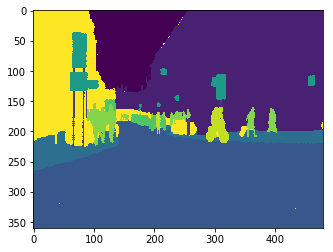

In [22]:
plt.imshow(np.array(img))

In [37]:
lnames

['/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0016E5_08400.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0006R0_f03750.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0016E5_06750.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0001TP_008010.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0016E5_05460.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0016E5_07740.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0001TP_007830.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0006R0_f01140.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0006R0_f03510.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0006R0_f01410.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0016E5_07680.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0016E5_01890.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0016E5_08520.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/trainannot/0001TP_006690.png',
 '/mnt/fast_ai/SegNet-Tutorial/CamVid/tra

In [130]:
imgs = np.stack([open_image(fn) for fn in fnames])
labels = np.stack([open_image(fn) for fn in lnames])

In [132]:
test = np.stack([open_image(fn) for fn in fnames_test])
test_labels = np.stack([open_image(fn) for fn in lnames_test])

In [126]:
imgs.shape,labels.shape,test.shape

((367, 360, 480, 3), (367, 360, 480), (233, 360, 480, 3))

In [135]:
imgs = imgs/255.

In [136]:
test=test/255

In [24]:
save_array('/mnt/fast_ai/tiramisu/imgs2.bc', imgs)
save_array('/mnt/fast_ai/tiramisu/labels2.bc', labels)

can start from here...

In [3]:
imgs = load_array('/mnt/fast_ai/tiramisu/imgs2.bc')
labels = load_array('/mnt/fast_ai/tiramisu/labels2.bc')

In [4]:
#imgs = load_array(PATH+'results/imgs.bc')
#labels = load_array(PATH+'results/labels.bc')

In [48]:
n,r,c,ch = imgs.shape

In [138]:
imgs-=0.4
imgs/=0.3
test-=0.4
test/=0.3

## Preprocessing

### Generator

In [51]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [52]:
bi = BatchIndices(10,3)
[next(bi) for o in range(7)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8])]

In [9]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([0, 8, 9]),
 array([7, 1, 6]),
 array([3, 4, 5]),
 array([2]),
 array([1, 8, 4])]

In [53]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.rows, self.cols = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.rows)
        slice_c = self.get_slice(self.ci, self.cols)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

In [56]:
sg = segm_generator(imgs, labels, 4, train=False)

In [70]:
b_img, b_label = next(sg)

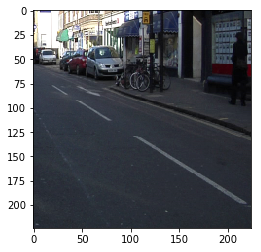

In [71]:
plt.imshow(b_img[0]*0.3+0.4);

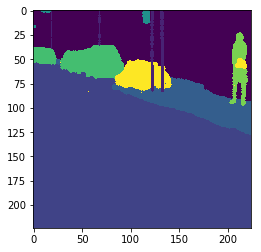

In [72]:
plt.imshow(b_label[0].reshape(224,224));

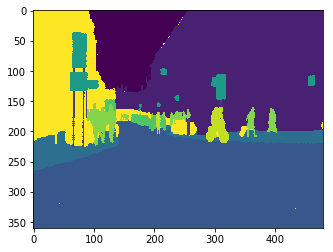

In [12]:
plt.imshow(labels[0])

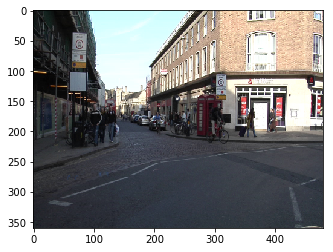

In [13]:
plt.imshow(imgs[0]*0.3+0.4);

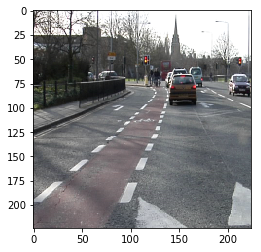

In [14]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### Convert labels

In [15]:
def parse_code(l):
    a,b = l.strip().split("\t")
    return tuple(int(o) for o in a.split(' ')), b

In [16]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            o=label_codes[a[j,k]]
            res[j,k] = o
    return res

In [40]:
label_codes,label_names = zip(*[parse_code(l) for l in open(PATH+"label_colors.txt")])

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/fast_ai/SegNet-Tutorial/CamVid/label_colors.txt'

In [39]:
label_codes,label_names = list(label_codes),list(label_names)

NameError: name 'label_codes' is not defined

In [40]:
list(zip(label_codes,label_names))[:5]

NameError: name 'label_codes' is not defined

In [75]:
#donno if i needit but heck letitbe
label_codes=[(64, 128, 64),(192, 0, 128),(0, 128, 192),(0, 128, 64),(128, 0, 0),(128, 0, 50),(128, 50, 50),\
            (64, 32, 128),(64, 0, 192),(32, 32, 164),(164, 32, 192)]

In [18]:
label_names=[i for i in range(len(label_codes))]

In [19]:
label_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [73]:
imgs.shape

(367, 360, 480, 3)

In [76]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [77]:
failed_code = len(label_codes)+1
failed_code

12

In [78]:
label_codes.append((0,0,0))
#label_names.append('unk')

In [79]:
arrays = [np.random.randn(3, 4) for _ in range(10)]

In [80]:
arrays[0].shape

(3, 4)

In [26]:
from collections import Counter
Counter(labels.flatten())

Counter({0: 10682767,
         1: 14750079,
         2: 623349,
         3: 20076880,
         4: 2845085,
         5: 6166762,
         6: 743859,
         7: 714595,
         8: 3719877,
         9: 405385,
         10: 184967,
         11: 2503995})

In [81]:
def conv_one_label(i): 
    # r=rows=360, c=cols=480
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[(labels[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [82]:
from concurrent.futures import ProcessPoolExecutor

In [83]:
def conv_all_labels():
    #n= train exmples
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

In [84]:
%time labels_int =conv_all_labels()

CPU times: user 120 ms, sys: 200 ms, total: 320 ms
Wall time: 4.69 s


In [33]:
np.unique(labels_int)

array([12], dtype=uint8)

In [34]:
np.unique(labels_int)

array([12], dtype=uint8)

In [37]:
labels_int[labels_int==failed_code]=0

In [86]:
labels_int.shape

(367, 360, 480)

In [40]:
save_array(PATH+'results/labels_int.bc', labels_int)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/fast_ai/SegNet-Tutorial/CamVid/results/labels_int.bc'

In [ ]:
labels_int = load_array(PATH+'results/labels_int.bc')

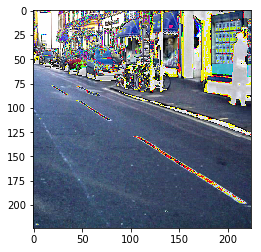

In [85]:
plt.imshow(b_img[0])

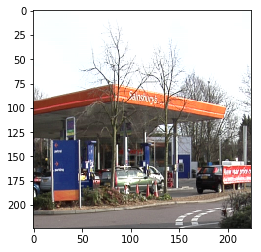

In [42]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);
#צריך להיות פה תמונה רגילה

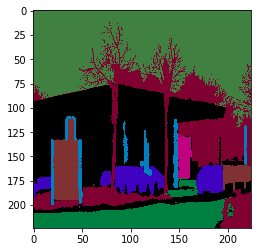

In [43]:
plt.imshow(color_label(np.resize(b_label[0], (224,224))));

### Test set

In [92]:
labels_int = labels

In [93]:
%cd /mnt/fast_ai/SegNet-Tutorial/CamVid/test/

/mnt/fast_ai/SegNet-Tutorial/CamVid/test


In [94]:
fn_test = set(o.strip() for o in open(PATH+'test.txt','r'))

In [117]:
len(fn_test)

233

In [101]:
fn_test=glob.glob(frames_test_path+'*.png')

In [102]:
is_test = np.array([o.split('/')[-1] in fn_test for o in fnames])

In [103]:
is_test

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, ..., False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False], dtype=bool)

In [100]:
trn = imgs[is_test==False]
trn_labels = labels_int[is_test==False]
test = imgs[is_test]
test_labels = labels_int[is_test]
trn.shape,test.shape

((367, 360, 480, 3), (0, 360, 480, 3))

(233, 360, 480)

In [111]:
e

(233, 360, 480, 3)

In [121]:
test=test.astype('float64')

In [124]:
test+=0.4
test*=0.3

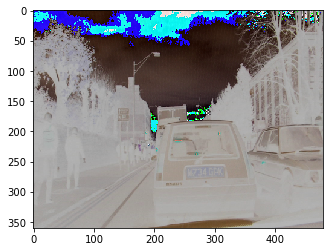

In [125]:
plt.imshow(test[0])

In [278]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## The Tiramisu

### The pieces

In [ ]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [ ]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [ ]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [143]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [144]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [145]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [147]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [5]:
#some ttrials
nb_classes=12
input_shape=[224,224,3]
img_input = Input(shape=input_shape)
nb_dense_block=6,
growth_rate=16
nb_filter=48

nb_layers=[4,5,7,10,12,15]
p=0.2
wd=1e-4

x = conv(img_input, nb_filter, 3, wd, 0)

skips,added = down_path(x, nb_layers, growth_rate, p, wd)
x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)

x = conv(x, nb_classes, 1, wd, 0)
_,r,c,f = x.get_shape().as_list()
x = Reshape((-1, nb_classes))(x)
Activation('softmax')(x)

NameError: name 'conv' is not defined

### Build the tiramisu model

In [148]:
def reverse(a): return list(reversed(a))

In [149]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

## Train

In [150]:
limit_mem()

In [151]:
input_shape = (224,224,3)

In [152]:
img_input = Input(shape=input_shape)

In [282]:
x = create_tiramisu(12, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [283]:
model = Model(img_input, x)

In [155]:
gen = segm_generator(trn, trn_labels, 3, train=True)

In [156]:
gen_test = segm_generator(test, test_labels, 3, train=False)

In [284]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [158]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [159]:
model.optimizer=keras.optimizers.RMSprop(1e-3)

In [285]:
K.set_value(model.optimizer.lr, 1e-3)

In [286]:
hist_folder='/mnt/fast_ai/SegNet-Tutorial/CamVid/models/weights224.{epoch:02d}-{val_loss:.2f}.hdf5'

def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint(hist_folder,
        verbose=1, save_weights_only=True)
          #  ,TQDMNotebookCallback(leave_inner=True)
            ]

In [ ]:
model.load_weights('/mntt/fast_ai/SegNet-Tutorial/CamVid/models/weights224.17-1.03.hdf5', by_name=True)

In [287]:
history=model.fit_generator(gen, rnd_trn, 100, verbose=1, 
                    callbacks=callbacks,validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/100
367/367 [==============================] - 289s - loss: 2.5579 - acc: 0.4855 - val_loss: 2.3163 - val_acc: 0.5032
Epoch 2/100
367/367 [==============================] - 188s - loss: 1.6370 - acc: 0.5737 - val_loss: 2.5047 - val_acc: 0.5146
Epoch 3/100
367/367 [==============================] - 189s - loss: 1.5007 - acc: 0.6006 - val_loss: 1.8977 - val_acc: 0.5840
Epoch 4/100
367/367 [==============================] - 189s - loss: 1.3381 - acc: 0.6299 - val_loss: 1.6982 - val_acc: 0.5963
Epoch 5/100
367/367 [==============================] - 189s - loss: 1.2363 - acc: 0.6498 - val_loss: 1.8265 - val_acc: 0.5670
Epoch 6/100
367/367 [==============================] - 189s - loss: 1.1780 - acc: 0.6685 - val_loss: 1.3278 - val_acc: 0.6690
Epoch 7/100
367/367 [==============================] - 189s - loss: 1.1209 - acc: 0.6783 - val_loss: 1.4897 - val_acc: 0.6047
Epoch 8/100
367/367 [==============================] - 189s - loss: 1.1238 - acc: 0.6763 - val_loss: 1.2422 - val_acc:

KeyboardInterrupt: 

In [ ]:
model.optimizer=keras.optimizers.RMSprop(3e-4, decay=1-0.9995)

In [ ]:
model.fit_generator(gen, rnd_trn, 500, verbose=1, 
                    validation_data=gen_test, nb_val_samples=100)

In [258]:
model.optimizer=keras.optimizers.RMSprop(2e-4, decay=1-0.9995)

In [259]:
model.fit_generator(gen, rnd_trn, 500, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/500
136s - loss: 0.3367 - acc: 0.9143 - val_loss: 0.5549 - val_acc: 0.8508
Epoch 2/500
117s - loss: 0.3432 - acc: 0.9119 - val_loss: 0.5744 - val_acc: 0.8429
Epoch 3/500
118s - loss: 0.3355 - acc: 0.9153 - val_loss: 0.5937 - val_acc: 0.8342
Epoch 4/500
117s - loss: 0.3441 - acc: 0.9115 - val_loss: 0.5675 - val_acc: 0.8379
Epoch 5/500
117s - loss: 0.3338 - acc: 0.9151 - val_loss: 0.5490 - val_acc: 0.8523
Epoch 6/500
117s - loss: 0.3390 - acc: 0.9132 - val_loss: 0.5408 - val_acc: 0.8520
Epoch 7/500
117s - loss: 0.3481 - acc: 0.9097 - val_loss: 0.5525 - val_acc: 0.8464
Epoch 8/500
117s - loss: 0.3434 - acc: 0.9125 - val_loss: 0.5431 - val_acc: 0.8538
Epoch 9/500
117s - loss: 0.3288 - acc: 0.9160 - val_loss: 0.6425 - val_acc: 0.8339
Epoch 10/500
117s - loss: 0.3368 - acc: 0.9133 - val_loss: 0.5633 - val_acc: 0.8376
Epoch 11/500
117s - loss: 0.3391 - acc: 0.9126 - val_loss: 0.5347 - val_acc: 0.8525
Epoch 12/500
117s - loss: 0.3249 - acc: 0.9176 - val_loss: 0.5775 - val_acc: 0.8413
E

KeyboardInterrupt: 

In [260]:
model.optimizer=keras.optimizers.RMSprop(1e-5, decay=1-0.9995)

In [261]:
model.fit_generator(gen, rnd_trn, 500, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/500
135s - loss: 0.2466 - acc: 0.9354 - val_loss: 0.5157 - val_acc: 0.8642
Epoch 2/500
117s - loss: 0.2629 - acc: 0.9290 - val_loss: 0.5258 - val_acc: 0.8581
Epoch 3/500
117s - loss: 0.2654 - acc: 0.9289 - val_loss: 0.4935 - val_acc: 0.8642
Epoch 4/500
118s - loss: 0.2555 - acc: 0.9323 - val_loss: 0.5139 - val_acc: 0.8575
Epoch 5/500
117s - loss: 0.2563 - acc: 0.9312 - val_loss: 0.5016 - val_acc: 0.8601
Epoch 6/500
117s - loss: 0.2600 - acc: 0.9308 - val_loss: 0.5194 - val_acc: 0.8602
Epoch 7/500
117s - loss: 0.2587 - acc: 0.9310 - val_loss: 0.5098 - val_acc: 0.8603
Epoch 8/500
117s - loss: 0.2628 - acc: 0.9300 - val_loss: 0.5219 - val_acc: 0.8579
Epoch 9/500
117s - loss: 0.2579 - acc: 0.9328 - val_loss: 0.4900 - val_acc: 0.8667
Epoch 10/500
117s - loss: 0.2590 - acc: 0.9305 - val_loss: 0.5170 - val_acc: 0.8603
Epoch 11/500
117s - loss: 0.2544 - acc: 0.9331 - val_loss: 0.5003 - val_acc: 0.8577
Epoch 12/500
117s - loss: 0.2550 - acc: 0.9320 - val_loss: 0.5210 - val_acc: 0.8555
E

KeyboardInterrupt: 

### large model

In [320]:
lrg_sz = (352,480)
gen = segm_generator(trn, trn_labels, 2, out_sz=lrg_sz, train=True)
gen_test = segm_generator(test, test_labels, 2, out_sz=lrg_sz, train=False)

In [321]:
lrg_shape = lrg_sz+(3,)
lrg_input = Input(shape=lrg_shape)

In [322]:
x = create_tiramisu(12, lrg_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [323]:
lrg_model = Model(lrg_input, x)

In [369]:
lrg_model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-4), metrics=["accuracy"])

In [368]:
lrg_model.load_weights(PATH+'results/tmp2.h5')

KeyError: "Can't open attribute (Can't locate attribute: 'weight_names')"

In [326]:
lrg_model.fit_generator(gen, rnd_trn, 100, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/100
393s - loss: 0.2116 - acc: 0.9453 - val_loss: 0.5031 - val_acc: 0.8720
Epoch 2/100
346s - loss: 0.2048 - acc: 0.9471 - val_loss: 0.4961 - val_acc: 0.8741
Epoch 3/100
346s - loss: 0.2032 - acc: 0.9476 - val_loss: 0.5058 - val_acc: 0.8703
Epoch 4/100
346s - loss: 0.1988 - acc: 0.9487 - val_loss: 0.5030 - val_acc: 0.8678
Epoch 5/100
346s - loss: 0.1985 - acc: 0.9487 - val_loss: 0.5042 - val_acc: 0.8727
Epoch 6/100
346s - loss: 0.1981 - acc: 0.9489 - val_loss: 0.4969 - val_acc: 0.8742
Epoch 7/100
346s - loss: 0.1955 - acc: 0.9494 - val_loss: 0.5067 - val_acc: 0.8693
Epoch 8/100
346s - loss: 0.1953 - acc: 0.9497 - val_loss: 0.5183 - val_acc: 0.8720
Epoch 9/100


KeyboardInterrupt: 

In [370]:
lrg_model.fit_generator(gen, rnd_trn, 100, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/100
377s - loss: 0.1894 - acc: 0.9511 - val_loss: 0.5339 - val_acc: 0.8654
Epoch 2/100
341s - loss: 0.1925 - acc: 0.9497 - val_loss: 0.5348 - val_acc: 0.8595
Epoch 3/100
342s - loss: 0.1865 - acc: 0.9521 - val_loss: 0.4922 - val_acc: 0.8751
Epoch 4/100
341s - loss: 0.1875 - acc: 0.9514 - val_loss: 0.5100 - val_acc: 0.8751
Epoch 5/100
341s - loss: 0.1902 - acc: 0.9509 - val_loss: 0.4954 - val_acc: 0.8755
Epoch 6/100
341s - loss: 0.1869 - acc: 0.9516 - val_loss: 0.5136 - val_acc: 0.8686
Epoch 7/100
342s - loss: 0.1899 - acc: 0.9504 - val_loss: 0.5182 - val_acc: 0.8734
Epoch 8/100
343s - loss: 0.1884 - acc: 0.9506 - val_loss: 0.5827 - val_acc: 0.8533
Epoch 9/100
344s - loss: 0.1843 - acc: 0.9529 - val_loss: 0.5236 - val_acc: 0.8715
Epoch 10/100
344s - loss: 0.1887 - acc: 0.9509 - val_loss: 0.5538 - val_acc: 0.8613
Epoch 11/100
344s - loss: 0.1843 - acc: 0.9523 - val_loss: 0.5364 - val_acc: 0.8686
Epoch 12/100
344s - loss: 0.1871 - acc: 0.9511 - val_loss: 0.5568 - val_acc: 0.8641
E

KeyboardInterrupt: 

In [371]:
lrg_model.optimizer=keras.optimizers.RMSprop(1e-5)

In [372]:
lrg_model.fit_generator(gen, rnd_trn, 2, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/2
367s - loss: 0.1873 - acc: 0.9510 - val_loss: 0.5111 - val_acc: 0.8729
Epoch 2/2
344s - loss: 0.1825 - acc: 0.9525 - val_loss: 0.4921 - val_acc: 0.8758


In [375]:
lrg_model.save_weights(PATH+'results/8758.h5')

## View results

In [99]:
colors = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128), (0, 0, 192),
         (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128), (64, 64, 0),
         (0, 128, 192), (0, 0, 0)]
names = ['sky', 'building', 'column_pole', 'road', 'sidewalk', 'tree', 
                'sign', 'fence', 'car', 'pedestrian', 'bicyclist', 'void']

In [382]:
gen_test = segm_generator(test, test_labels, 2, out_sz=lrg_sz, train=False)

In [221]:
persons=glob.glob('/mnt/vidme/vid1/*.png')

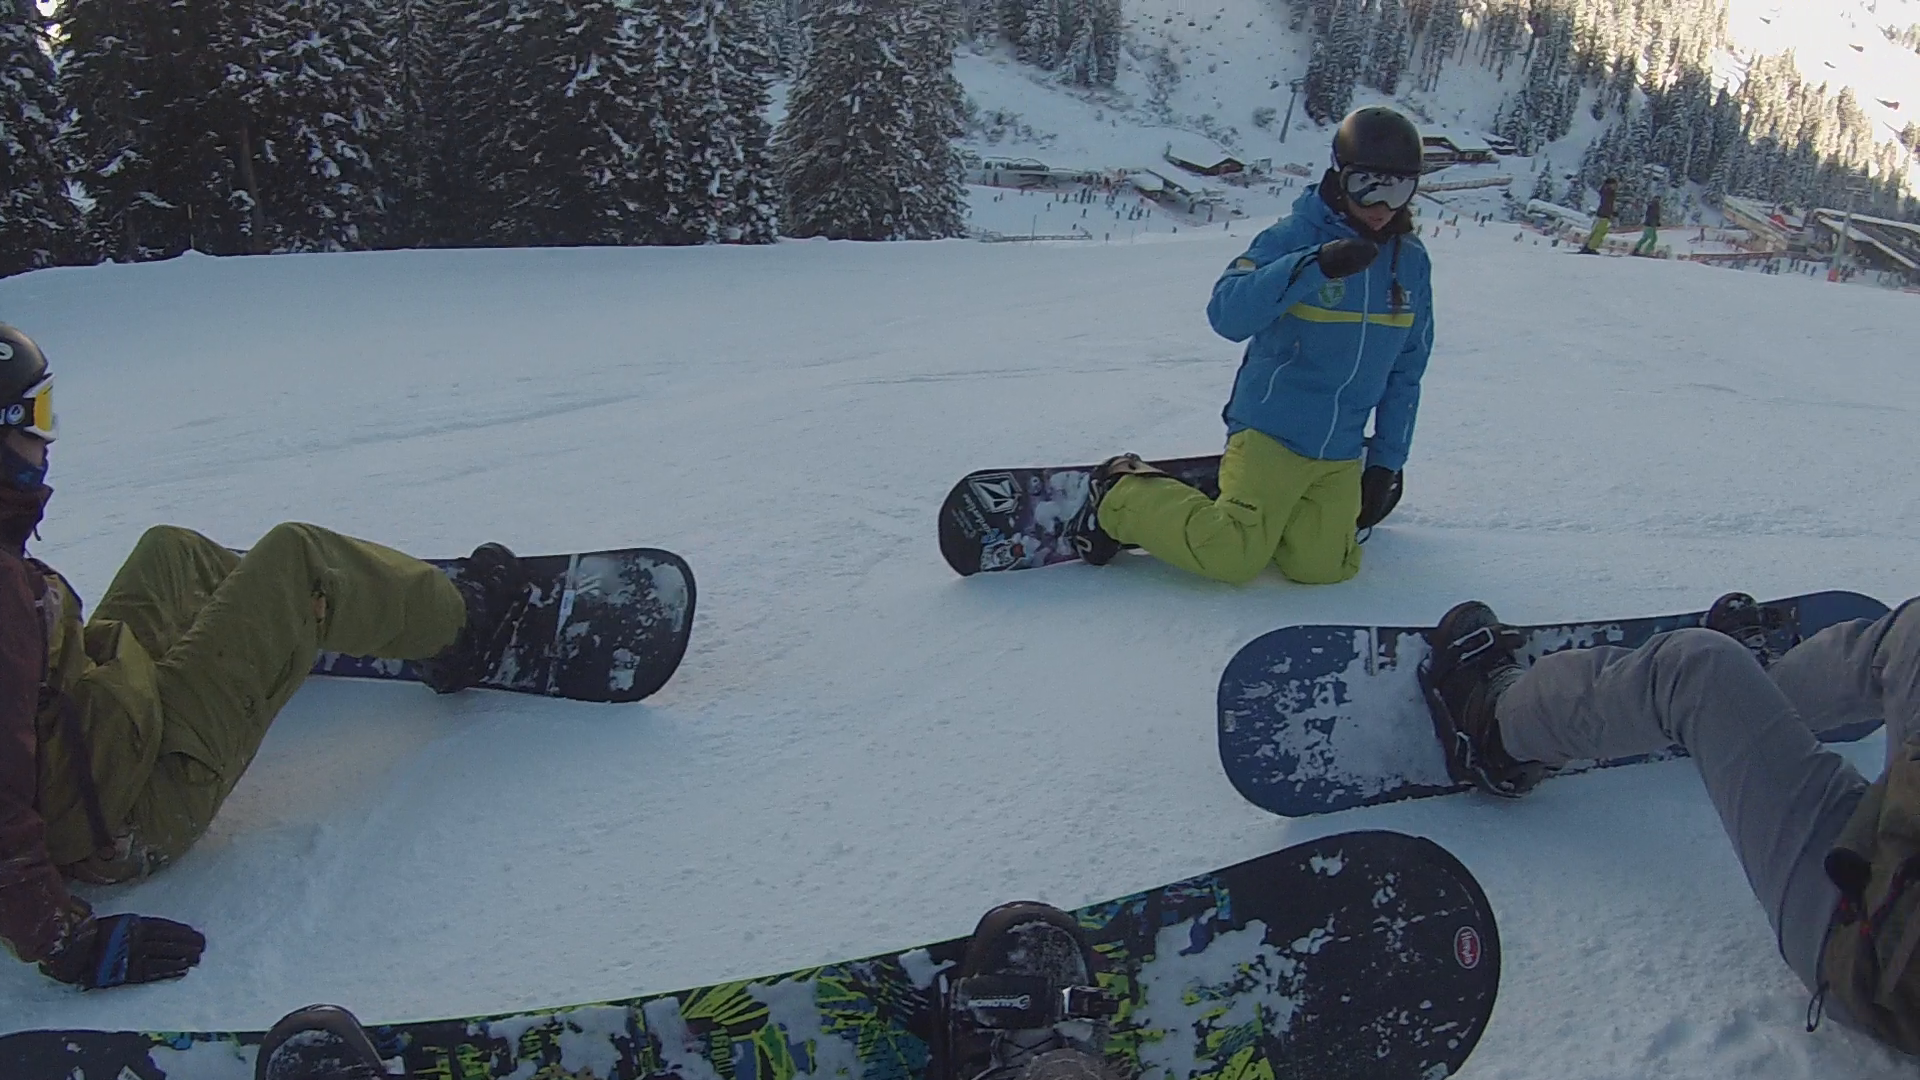

In [230]:
Image.open(persons[15])

In [233]:
#ohhhh try vidme
wend=np.array(Image.open(persons[15]).resize([224,224]))

In [293]:
a=[]
for i in range(10):
    a.append(next(gen))

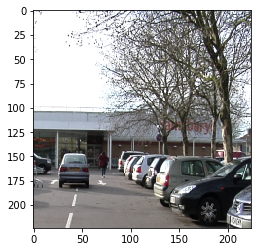

In [301]:
plt.imshow(((a[0][0][2]*0.3+0.4)))

In [305]:
np.max(a[0][1][2])

11

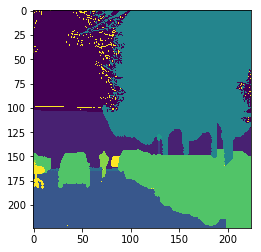

In [306]:
#tags
tags = a[0][1][2].reshape((-1,224,224))
plt.imshow(tags[0])

In [317]:
#print some accuracies
for i in range(10):
    tags = a[i][1][2].reshape((-1,224,224))
    pred=model.predict(a[i][0])
    
    pred = np.argmax(pred, axis=-1)
    pred = pred.reshape((-1,224,224))
    print(np.sum((np.abs(pred[2]-tags)[0])==0)/(224**2))

0.878806600765
0.568439094388
0.850446428571
0.784837372449
0.850227200255
0.91432158801
0.941844706633
0.870037468112
0.677594866071
0.477479272959


In [318]:
a[i][1][2].shape

(50176, 1)

In [258]:
np.min(a[0][0][2]*0.3+0.4)

0.0

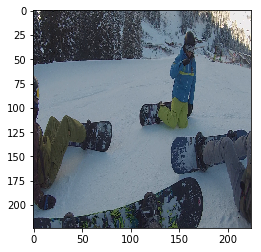

In [291]:
plt.imshow((wend/255))

In [308]:
pred=model.predict(a[0][0])
pred = np.argmax(pred, axis=-1)
pred = pred.reshape((-1,224,224))

In [288]:
pred=model.predict(np.expand_dims((wend/255-0.4)/0.3,0))

In [208]:
pred.shape

(1, 224, 224)

In [211]:
pred.shape

(3, 224, 224)

In [289]:
pred = np.argmax(pred, axis=-1)
pred = pred.reshape((-1,224,224))

In [213]:
pred[2].shape

(224, 224)

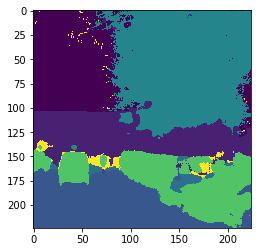

In [309]:
plt.imshow(pred[2])

In [101]:
preds = model.predict_generator(gen, rnd_trn)
preds = np.argmax(preds, axis=-1)
preds = preds.reshape((-1,352,480))

ValueError: total size of new array must be unchanged

In [103]:
preds = preds.reshape((-1,224,224))

In [ ]:
trn[:10]

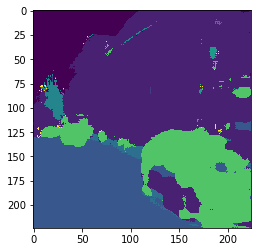

In [121]:
plt.imshow(preds[0])

In [116]:
target = trn_labels.reshape((367,360,480))[:,8:]

In [117]:
(target == preds).mean()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


AttributeError: 'bool' object has no attribute 'mean'

In [118]:
non_void = target != 11
(target[non_void] == preds[non_void]).mean()

IndexError: index 224 is out of bounds for axis 1 with size 224

In [107]:
idx=1

In [108]:
p=model.predict(np.expand_dims(test[idx,8:],0))
p = np.argmax(p[0],-1).reshape(352,480)
pred = color_label(p)

IndexError: index 1 is out of bounds for axis 0 with size 0

In [104]:
plt.imshow(pred);

NameError: name 'pred' is not defined

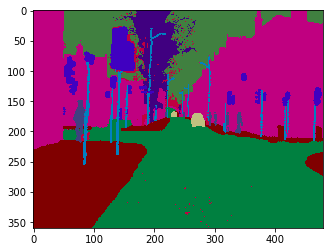

In [389]:
plt.imshow(color_label(test_labels[idx]));

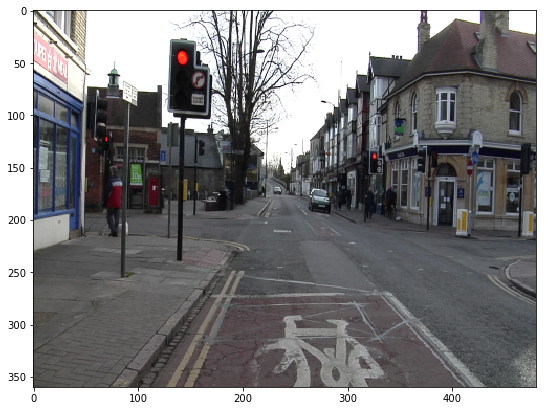

In [392]:
plt.figure(figsize=(9,9))
plt.imshow(test[idx]*0.3+0.4)

## End